## ****PCA and t-SNE Project: Auto MPG****

## Project Overview
This project explores the structure of the Auto MPG dataset using dimensionality reduction and clustering techniques. The goal is to understand how vehicle characteristics such as engine size, weight, horsepower, and fuel efficiency relate to one another and to identify natural groupings of vehicles based on these features.

The analysis focuses on uncovering patterns in the data rather than building a predictive model.


-----------------------------
## **Context**
-----------------------------

Understanding the underlying structure of high-dimensional data is a common challenge in real-world analytics. In this project, dimensionality reduction techniques are applied to the Auto MPG dataset to uncover latent patterns in vehicle characteristics and explore natural groupings among cars.

The analysis focuses on transforming correlated numerical features into a lower-dimensional representation that preserves meaningful variation in the data. This allows for clearer visualization, interpretation, and segmentation without relying on supervised labels.

-----------------------------
## **Objective**
-----------------------------
The objective of this problem is to explore the data, apply PCA in order to reduce dimensionality while retaining most of the original variance, use t-SNE as a complementary method to visualize complex structures, and extract meaningful insights.

-----------------------------
## **Dataset**
-----------------------------
There are 8 variables in the data:

- mpg: miles per gallon
- cyl: number of cylinders
- disp: engine displacement (cu. inches) or engine size
- hp: horsepower
- wt: vehicle weight (lbs.)
- acc: time taken to accelerate from 0 to 60 mph (sec.)
- yr: model year
- car name: car model name

## **Importing the necessary libraries and overview of the dataset**

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

# Importing PCA and t-SNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.manifold import TSNE

### **Loading the data**

### **Data Overview**





NOTE: The raw dataset is not included in this repository because it is part of an MIT-affiliated course

In [59]:
# loading the data
cars_csv = ("data/auto-mpg.csv")

In [60]:
# creating a dataframe copy
df = cars_csv.copy()

In [61]:
# checking the first 5 rows
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,car name
0,18.0,8,307.0,130,3504,12.0,70,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,ford torino


In [62]:
# getting the general info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   car name      398 non-null    object 
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


The dataset contains 398 rows and 8 columns with no missing values. Most variables are stored in appropriate numeric formats (int64 and float64). Two columns, however, "horsepower" and "car name" are stored as object types. While car name is categorical and should remain an object, the horsepower column represents numeric engine power and must be cleaned and converted to a numeric dtype before further analysis. This step is essential because the current object format indicates the presence of non-numeric values or formatting issues within the column.

## **Data Preprocessing and Exploratory Data Analysis**


In [63]:
# converting horsepower column to numeric
df["horsepower"] = pd.to_numeric(df["horsepower"], errors="coerce")

In [64]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0


The summary statistics show that vehicles in the dataset achieve an average fuel efficiency of approximately 23.5 mpg. Vehicle weight varies widely (from 1,613 to 5,140 lbs), indicating a mix of lighter compact cars and heavier models. The average model year is around 1976, within a range of 1970-1982, confirming that the dataset primarily covers older vehicles. The average number of cylinders is 5.45, suggesting the presence of multiple engine configurations.


In [65]:
# checking if there are any missing values in the column
df["horsepower"].isnull().sum()

np.int64(6)

As we can see, there are 6 NaN values that appeared after the conversion. Therefore, we need to replace them with real numeric values so they do not affect our analysis later on.

In [66]:
# replacing the NaN values
df["horsepower"] = df["horsepower"].fillna(df["horsepower"].median())

Based on the summary statistics, the range of the "horsepower" column is quite large (from 46 to 230) while the average is only 104. Using the mean would make the replacement inaccurate due to this wide spread, so replacing the NaN values with the median is more appropriate.

In [67]:
df["horsepower"].isna().sum()

np.int64(0)

After replacing the missing values with the median horsepower, the column now contains 0 NaN values, and we can move on. The only remaining object-type column is ‘car_name’, which does not provide useful predictive information, so we will drop it to avoid adding noise or causing overfitting.

In [68]:
df.drop("car name", axis=1, inplace=True)

**Univariate Analysis**

Now that all columns are numeric, we can proceed with the univariate analysis of each variable.

In [69]:
# creting a function to process the univariate analysis of each numerical column
def hist_boxplot(data, feature, figsize=(12,8), bins=None, color ="royalblue"):
  fig, (ax_box, ax_hist) = plt.subplots(nrows=2, sharex=True, figsize=figsize)

  sns.boxplot(data=data, x=feature, ax=ax_box, color=color, showmeans=True)

  if bins == None:
    sns.histplot(data=data, x=feature, ax=ax_hist, kde=True, color=color)
  else:
    sns.histplot(data=data, x=feature, ax=ax_hist, kde=True, color=color,
               bins=bins)

  ax_hist.axvline(data[feature].mean(), color="green", linestyle="--")
  ax_hist.axvline(data[feature].median(), color="red", linestyle="-")

  plt.tight_layout()
  plt.show()

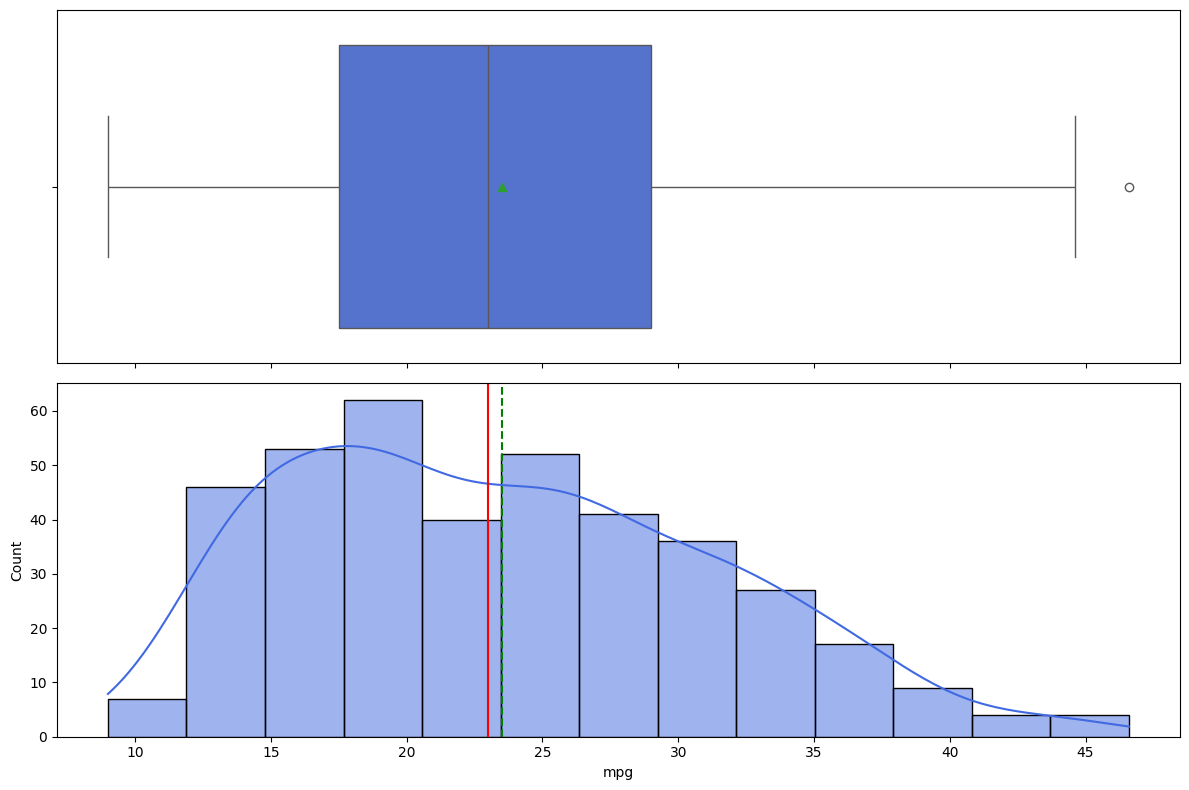

In [70]:
hist_boxplot(df, "mpg")

The mean and median mpg are very close, indicating a roughly symmetrical distribution. Most cars achieve around 23 miles per gallon. There is a high concentration of vehicles in the 15-20 mpg range, while fewer cars reach above 25 mpg. Only one mild outlier appears on the higher end of the distribution.

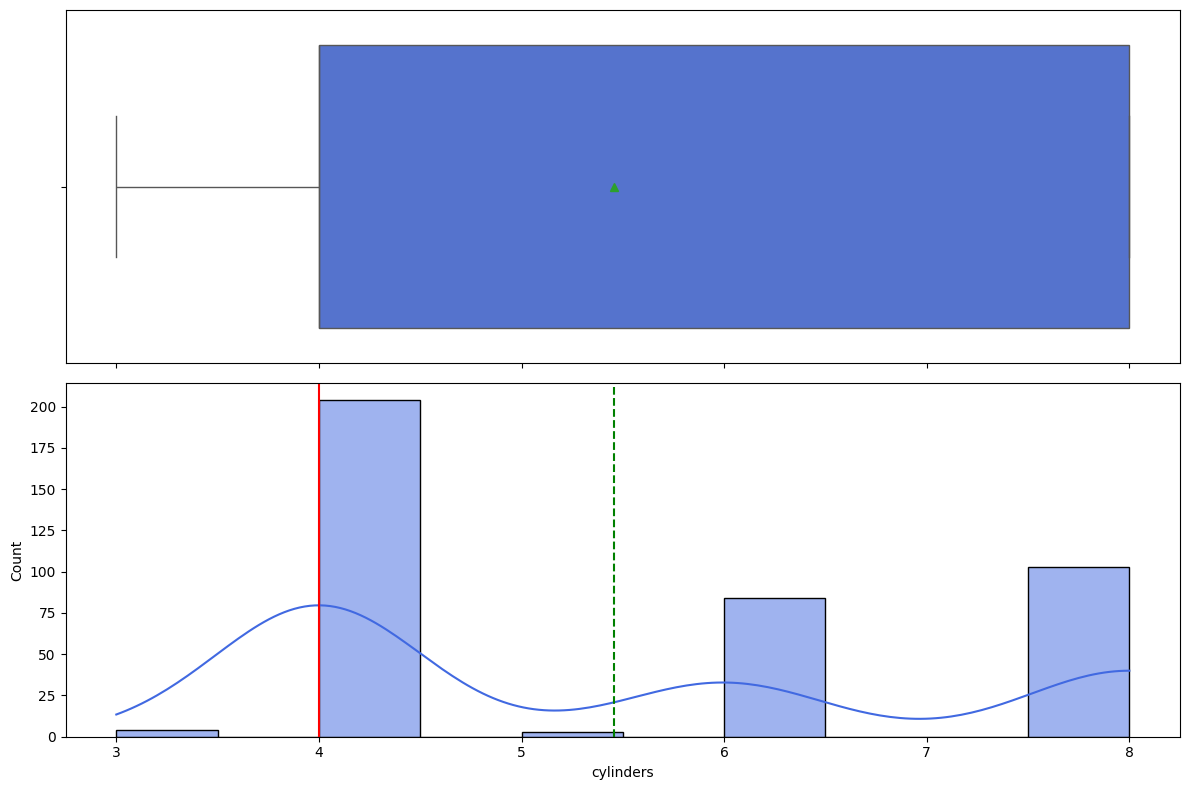

In [71]:
hist_boxplot(df, "cylinders")

The distribution of cylinders is right-skewed. Most cars in the dataset have 4 cylinders, while a smaller number of vehicles (typically larger or more powerful models) have 6 or 8 cylinders.

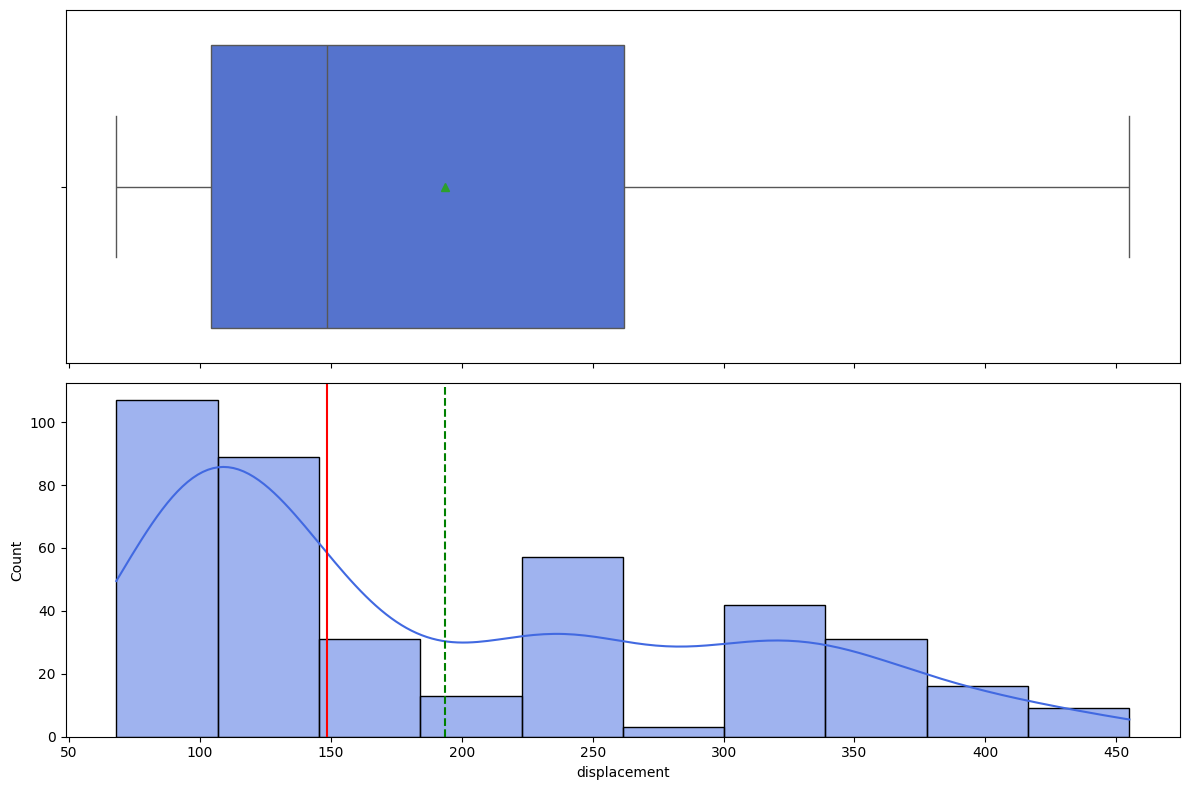

In [72]:
hist_boxplot(df, "displacement")

Engine displacement varies widely across the dataset. Most vehicles are concentrated at lower displacement values, while a smaller group has much larger engines, creating a right-skewed distribution. This reflects the mix of more fuel-efficient cars and heavier vehicles with larger engines that are typically associated with higher performance or different driving needs.

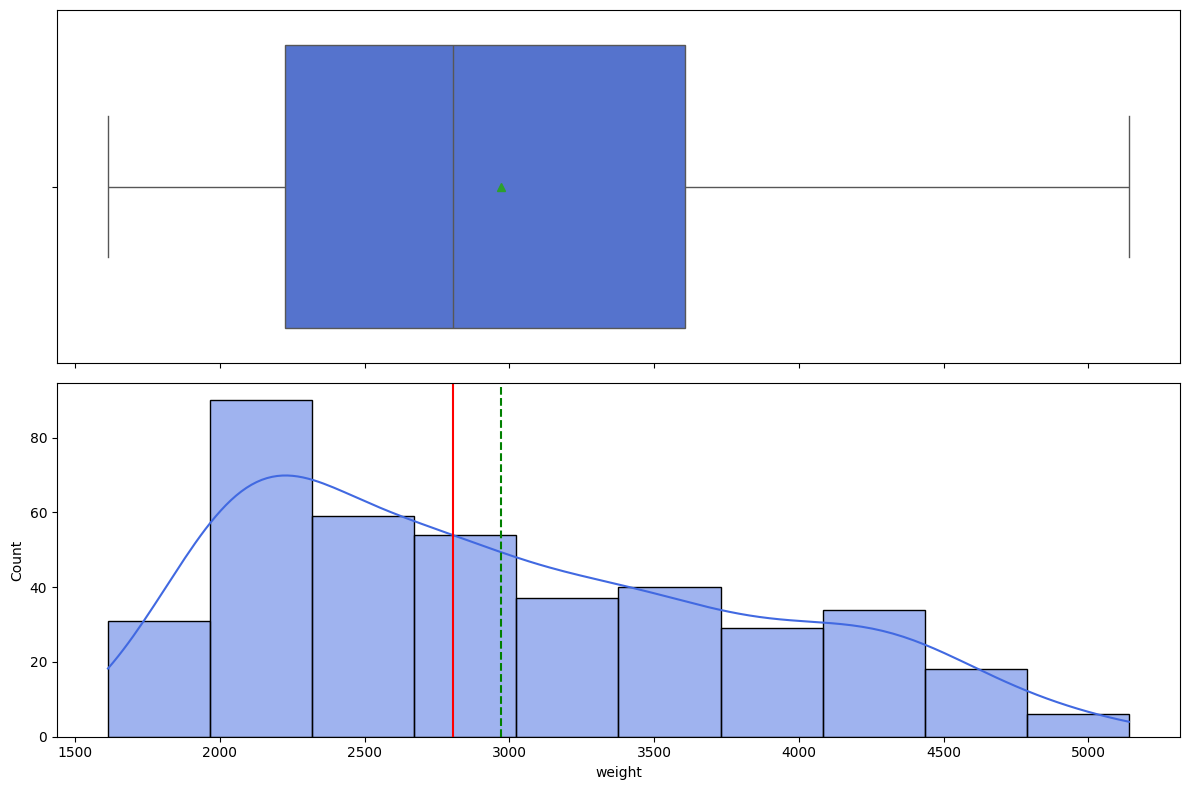

In [73]:
hist_boxplot(df, "weight")

The mean and median vehicle weights are relatively close, falling between 2,800 and 3,000 pounds, which suggests a moderately skewed distribution. Most vehicles cluster around 2,000-3,000 pounds, while heavier cars become less frequent toward the upper end of the distribution. Although the distribution has a right tail, there are no clear extreme outliers in vehicle weight.

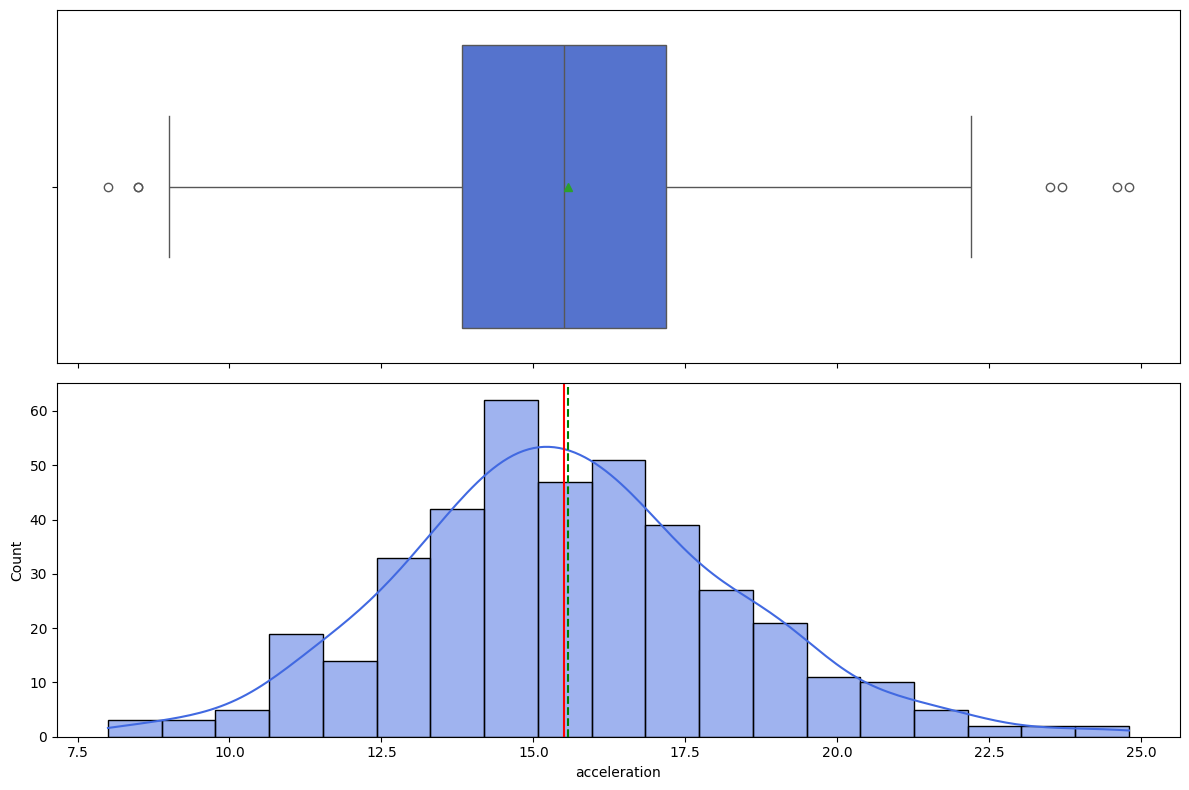

In [74]:
hist_boxplot(df, "acceleration")

Acceleration appears normally distributed, forming a bell-shaped curve. The mean and median are very close, around 15.3 seconds, indicating a symmetrical distribution. A few mild outliers exist on both the lower and higher ends, but overall the values cluster tightly around the center.



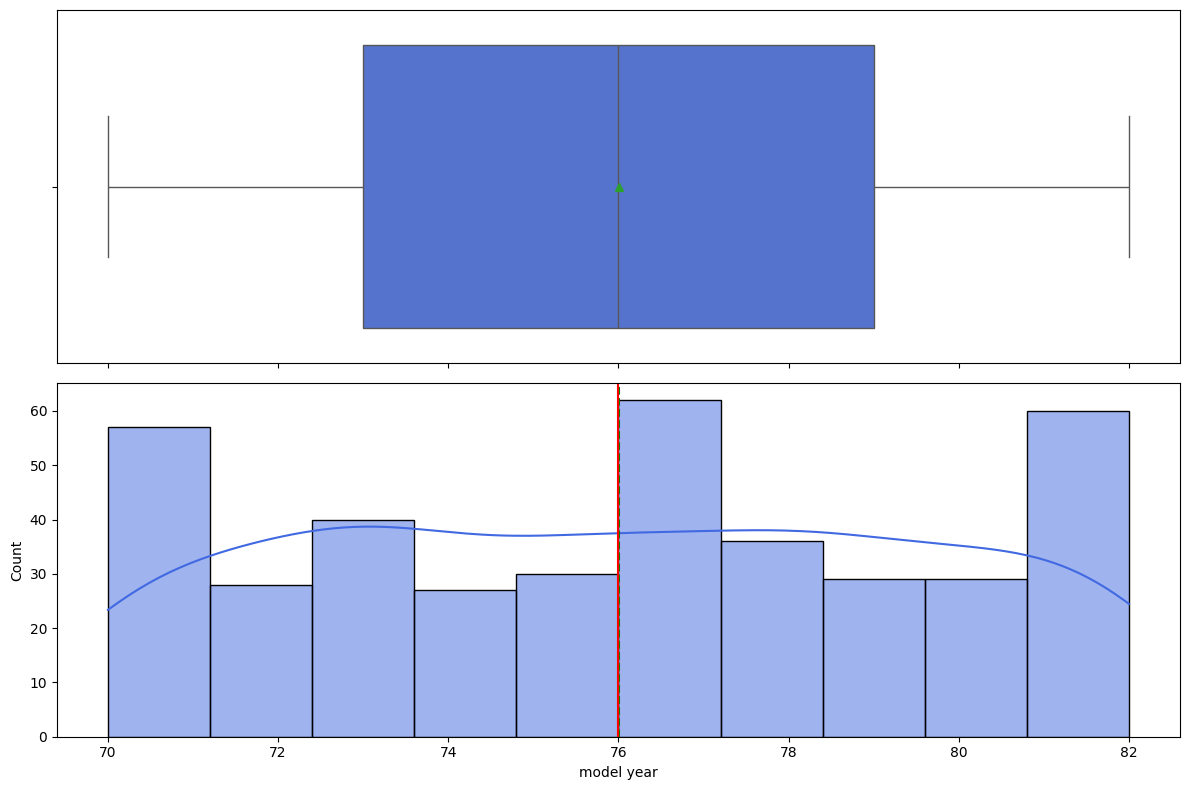

In [75]:
hist_boxplot(df, "model year")

The model years range from 1970 to 1982, with no vehicles outside this period. The distribution shows several peaks, with larger concentrations around 1970, 1976, and 1982.

In [76]:
# creating a correlation tablet
df.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year
mpg,1.000000,-0.775396,-0.804203,-0.773453,-0.831741,0.420289,0.579267
cylinders,-0.775396,1.000000,0.950721,0.841284,0.896017,-0.505419,-0.348746
displacement,-0.804203,0.950721,1.000000,0.895778,0.932824,-0.543684,-0.370164
horsepower,-0.773453,0.841284,0.895778,1.000000,0.862442,-0.686590,-0.413733
weight,-0.831741,0.896017,0.932824,0.862442,1.000000,-0.417457,-0.306564
acceleration,0.420289,-0.505419,-0.543684,-0.686590,-0.417457,1.000000,0.288137
model year,0.579267,-0.348746,-0.370164,-0.413733,-0.306564,0.288137,1.000000


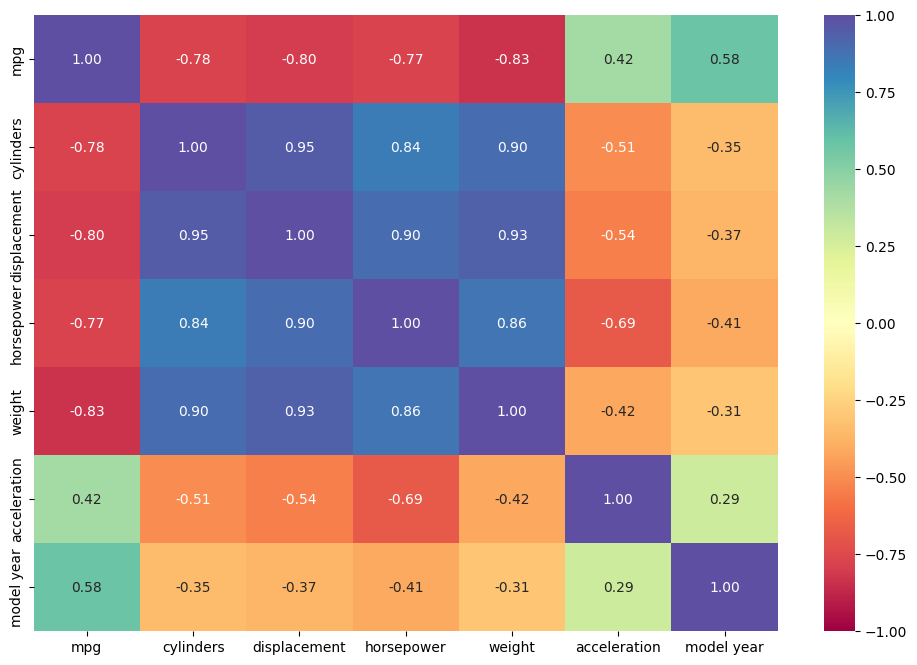

In [77]:
# plotting the correlation
plt.figure(figsize=(12,8))

sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap="Spectral", fmt=".2f")
plt.show()

The variables "weight", "cylinders", "displacement", and "horsepower" are all strongly positively correlated with each other, forming one multicollinearity cluster that represents car size and engine power. These size-related variables also show strong negative correlations with mpg, indicating that larger and more powerful cars tend to have lower fuel efficiency. Model year shows a moderate positive correlation with mpg.

**Bivariate Analysis**

In [78]:
# creating a plot function
def reg_plot(data, predictor, target, figsize=(12, 8)):
  plt.figure(figsize=figsize)

  sns.regplot(data=data, x=predictor, y=target,
              scatter_kws={"color": "green", "s":10}, lowess=True)

  plt.xlabel(predictor)
  plt.ylabel(target)
  plt.tight_layout()

  plt.show()

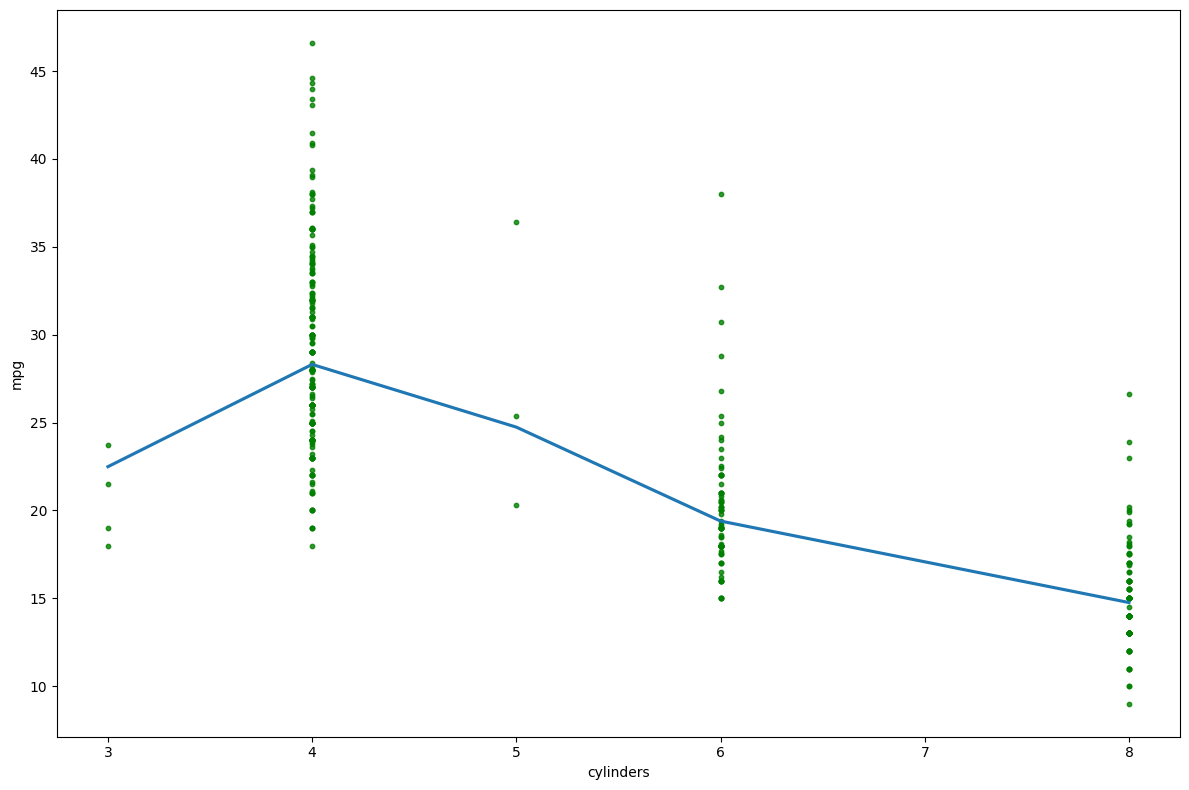

In [79]:
reg_plot(df, "cylinders", "mpg")

In [80]:
df.groupby("cylinders")["mpg"].mean()

,mpg
cylinders,
3,20.550000
4,29.286765
5,27.366667
6,19.985714
8,14.963107


Cars with fewer cylinders tend to have higher fuel efficiency (higher mpg), while cars with more cylinders show noticeably lower mpg. The chart illustrates that most 4 cylinder vehicles cluster at the highest mpg values, confirming that smaller engines generally require less fuel.

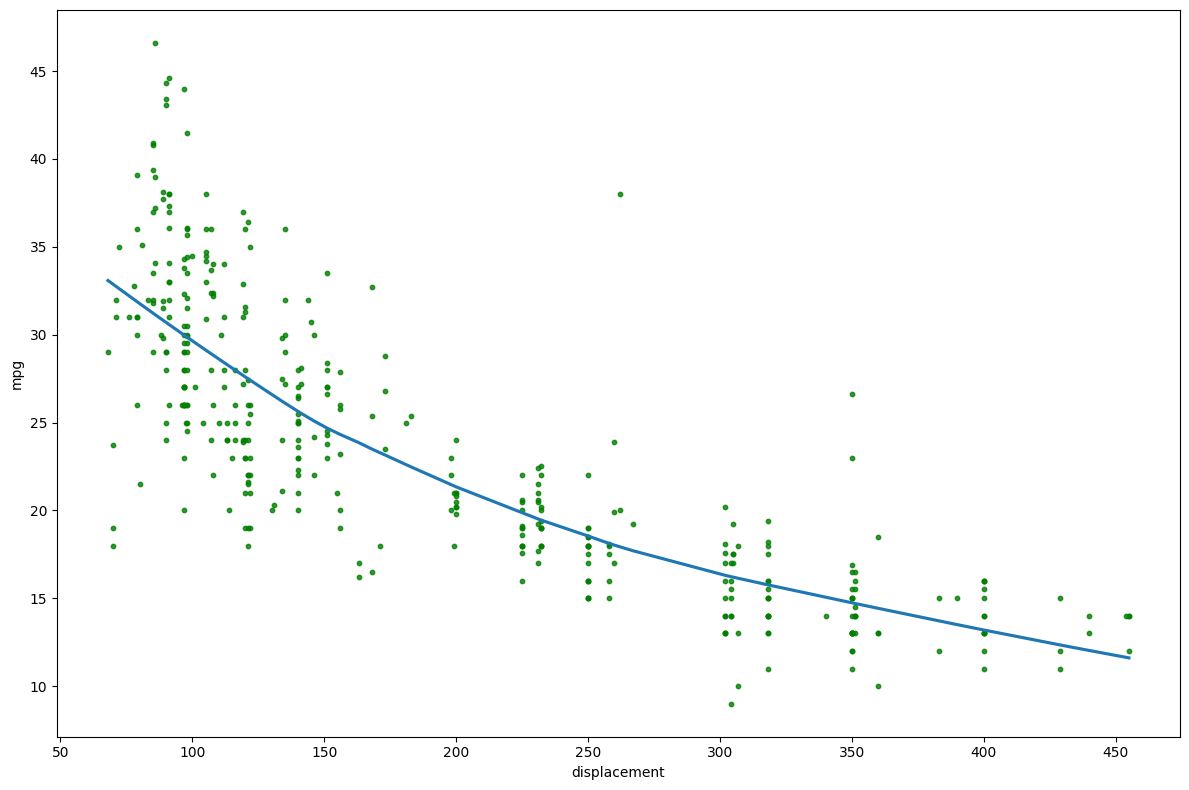

In [81]:
reg_plot(df, "displacement", "mpg")

In [82]:
df.groupby("displacement")["mpg"].agg(["mean", "median"])

,mean,median
displacement,,
68.0,29.000000,29.0
70.0,20.233333,19.0
71.0,31.500000,31.5
72.0,35.000000,35.0
76.0,31.000000,31.0
...,...,...
400.0,13.961538,14.0
429.0,12.666667,12.0
440.0,13.500000,13.5


As shown by both the graph and the grouped statistics, cars with smaller engine displacement achieve significantly higher mpg, with mean and median values often in the 29-35 mpg range. As displacement increases, fuel efficiency steadily declines, confirming a strong negative relationship between engine size and mpg.

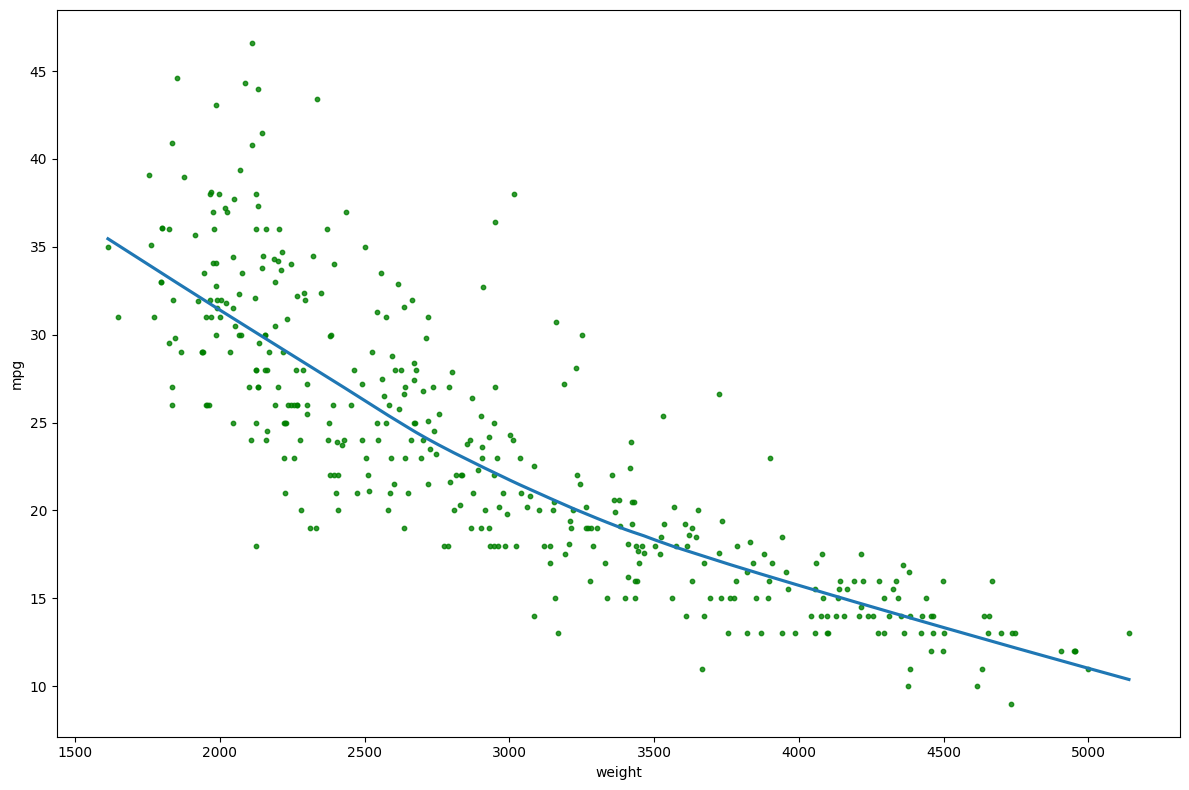

In [83]:
reg_plot(df, "weight", "mpg")

In [84]:
df.groupby(pd.cut(df["weight"], bins=6), observed=True)["mpg"].agg(["median", "count"])

,median,count
weight,,
"(1609.473, 2200.833]",32.00,92
"(2200.833, 2788.667]",26.00,103
"(2788.667, 3376.5]",20.40,76
"(3376.5, 3964.333]",17.55,62
"(3964.333, 4552.167]",14.00,49
"(4552.167, 5140.0]",12.50,16


Vehicle weight shows a strong negative relationship with fuel efficiency. Lighter cars, around 1600-2200 lbs, achieve around 32 mpg, while big cars (more than 4500 lbs) drop to 12-15 mpg. Both the regression trend and the binned medians confirm that mpg decreases consistently as weight increases.

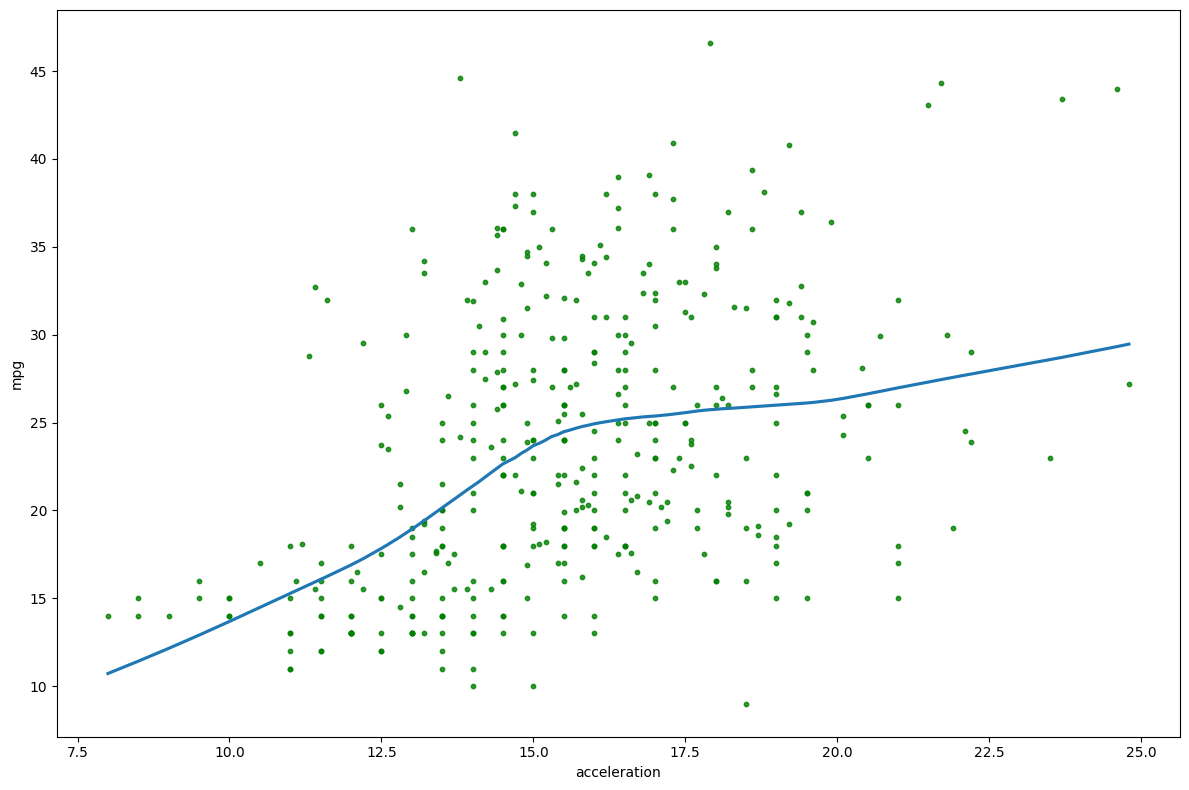

In [85]:
reg_plot(df, "acceleration", "mpg")

In [86]:
df.groupby(pd.cut(df["acceleration"], bins=5), observed=True)["mpg"].mean()

,mpg
acceleration,
"(7.983, 11.36]",15.185714
"(11.36, 14.72]",20.899265
"(14.72, 18.08]",25.363372
"(18.08, 21.44]",25.581034
"(21.44, 24.8]",31.945455


The graph shows that the relationship between acceleration and mpg is not perfectly linear. The curve rises gradually in the middle range. This indicates that cars with faster acceleration times (lower values) tend to be more powerful and therefore less efficient, while cars with slower acceleration times are generally lighter and achieve higher mpg. As acceleration increases, the average mpg rises as well, confirming a clear upward trend. This shows that acceleration can still be used as a predictor for mpg, even if the relationship is not perfectly linear.

### **Scaling the data**

In [87]:
scaler = StandardScaler()

In [88]:
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [89]:
df_scaled.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year
0,-0.706439,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426
1,-1.090751,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426
2,-0.706439,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426
3,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426
4,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426


The data has been normalized using standard scaling, which means each column now has a mean of 0 and a standard deviation of 1.

## **Principal Component Analysis**

In [90]:
# Set n to number of features in the dataset
n = df_scaled.shape[1]

In [91]:
pca=PCA(n_components=n, random_state=1)
df_pca1=pd.DataFrame(pca.fit_transform(df_scaled))
exp_var1 = pca.explained_variance_ratio_

In [92]:
exp_var1

array([0.71476787, 0.1236554 , 0.10414042, 0.02671968, 0.01778617,
       0.00790889, 0.00502158])

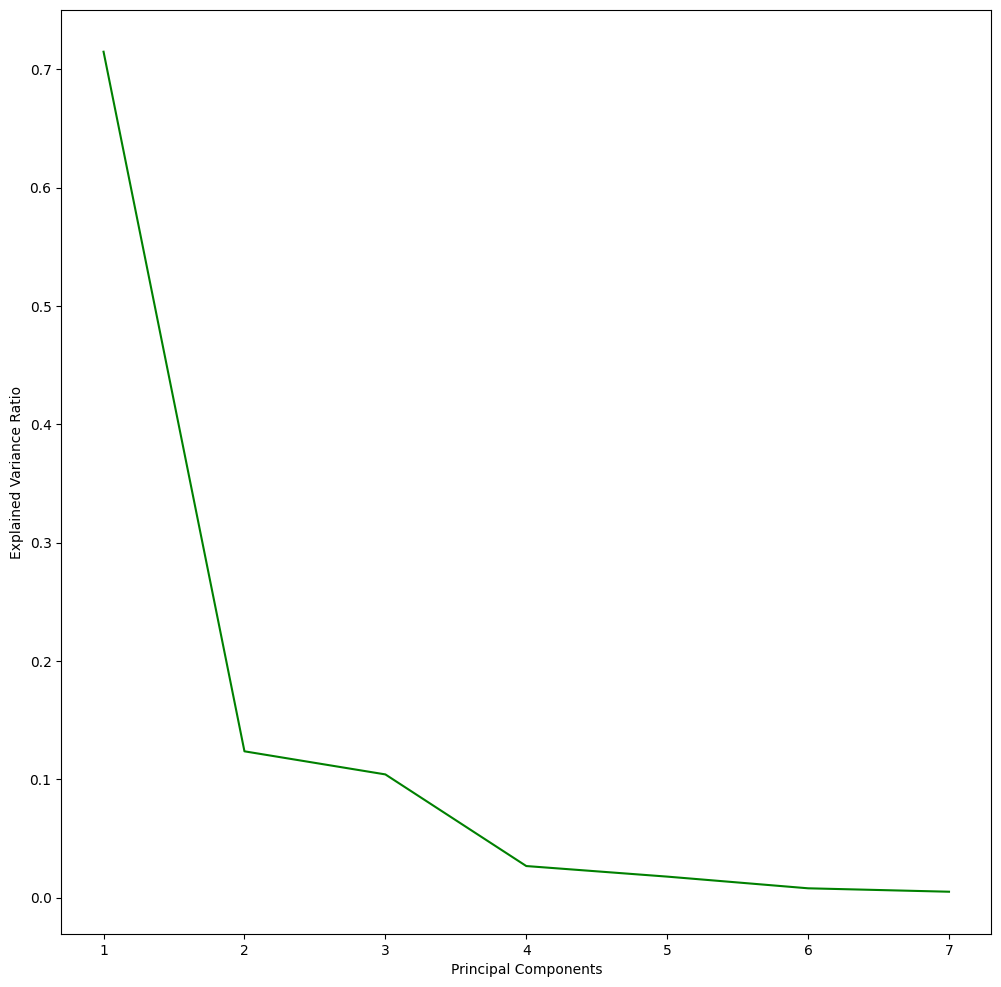

In [93]:
plt.figure(figsize=(12,12))

plt.plot(range(1, len(exp_var1) +1), exp_var1, color="green")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.show()

According to the graph, there is a clear drop in explained variance after the first two principal components, indicating an elbow at PC2. This suggests that the first two components capture most of the dominant structure in the data and are sufficient for visualization purposes. However, including a third component is also reasonable, as the first three principal components together explain over 90% of the total variance.

In [94]:
# finding the least # of components
total_var=0

for i_component, var in enumerate(exp_var1):
  total_var += var

  if total_var> 0.90:
    print("Number of components needed for 90% variance:", i_component+1)

    break


Number of components needed for 90% variance: 3


Based on the PCA results, the outcome matches what we saw in the graph: the first three principal components capture about 90% of the total information in the dataset. This means we can keep just these three and still have almost all of the important patterns for prediction.

#### **Interpret the coefficients of the first three principal components from the below DataFrame**

In [95]:
# Making a new dataframe with first 3 principal components
pc_list = ["PC1", "PC2", "PC3"]
pc_df = pd.DataFrame(np.round(pca.components_[:3,:], 2), index=pc_list,
  columns = df_scaled.columns)

In [96]:
# Transposing rows and columns for clarity
pc_df.T

,PC1,PC2,PC3
mpg,-0.40,0.21,-0.26
cylinders,0.42,0.19,0.14
displacement,0.43,0.18,0.10
horsepower,0.42,0.09,-0.17
weight,0.41,0.22,0.28
acceleration,-0.28,-0.02,0.89
model year,-0.23,0.91,-0.02


In PC1, the highest scorings belong to "displacement", "cylinders", and "horsepower". This means PC1 mainly captures the overall size and power of the car. These features are  negatively related to mpg, which confirms our earlier conclusion: bigger, heavier, and more powerful cars tend to be less fuel-efficient.

In PC2, the dominant loading is model year (0.91), which makes this component represent the age of the car. So PC2 separates older models from newer ones.

In PC3, the highest value is acceleration (0.89). This shows that acceleration is the key feature shaping this component. Cars differ noticeably in how quickly they accelerate, and this becomes an important factor that can influence fuel usage.

#### **Visualize the data in 2 dimensions using the first two principal components**



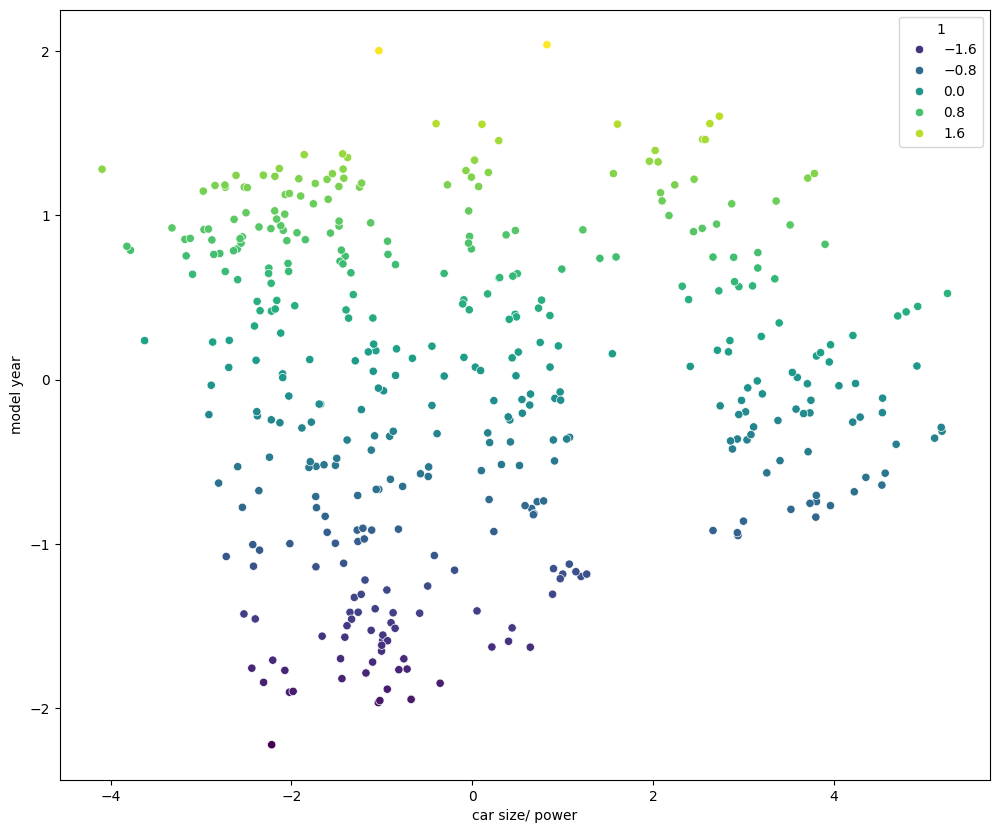

In [97]:
# visualizing the first 2 PCs

plt.figure(figsize=(12,10))

sns.scatterplot(x=df_pca1[0], y=df_pca1[1], hue=df_pca1[1], palette="viridis")

plt.xlabel("car size/ power")
plt.ylabel("model year")
plt.show()

For visualization purposes, the PCA scatterplot displays only PC1 and PC2, as these two components explain the largest share of variance and provide a clear two-dimensional representation of the data structure.

The plot shows a clear separation along PC1, which captures differences related to vehicle size and engine power. Negative PC1 values correspond to smaller, less powerful cars, which make up a large portion of the dataset. In contrast, positive PC1 values represent larger and more powerful vehicles, forming a distinct group on the right side of the plot.

The color gradient represents model year, with darker colors indicating older vehicles and lighter green shades corresponding to newer models. Cars are distributed across a wide range of model years throughout the plot, suggesting that vehicle size and power vary across time rather than being concentrated in a single period.

In [98]:
# Finding KMeans
kmeans = KMeans(n_clusters=2, random_state=1)
clusters = kmeans.fit_predict(df_pca1[[0, 1]])

df_pca1["cluster"] = kmeans.labels_

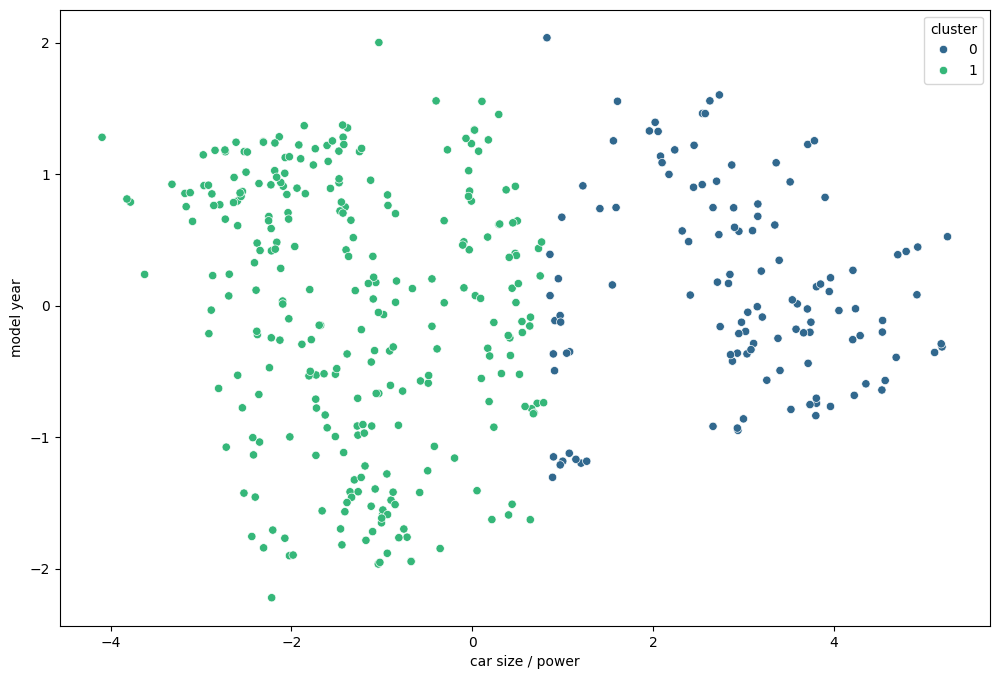

In [99]:
plt.figure(figsize=(12,8))

sns.scatterplot(x=df_pca1[0], y=df_pca1[1], hue=df_pca1["cluster"], palette="viridis")

plt.xlabel("car size / power")
plt.ylabel("model year")
plt.show()

Horsepower, engine size, weight, and mpg are the features that most strongly influence how the cars separate into two clusters. These features create a clear contrast between heavier, more powerful vehicles and lighter, more economical ones, which KMeans identifies as two distinct groups.

There are two different clusters: the green cluster groups together cars that have lower values on PC1 (smaller engines, lower horsepower, lighter weight).
The blue cluster groups cars with higher PC1 values (bigger engines, heavier bodies, more horsepower).
The green cluster contains more points, indicating that less powerful cars dominate the dataset, while high-power cars form a smaller, separate group.

## **t-SNE**

In [100]:
tsne = TSNE(n_components=2, random_state=1)
df_tsne = pd.DataFrame(tsne.fit_transform(df_scaled),
                       columns = ['Component 1', 'Component 2'])

In [101]:
df_tsne.head()

,Component 1,Component 2
0,36.707752,-2.108404
1,37.192513,-0.058722
2,37.241322,-1.185374
3,36.654381,-1.296686
4,37.348392,-1.658431


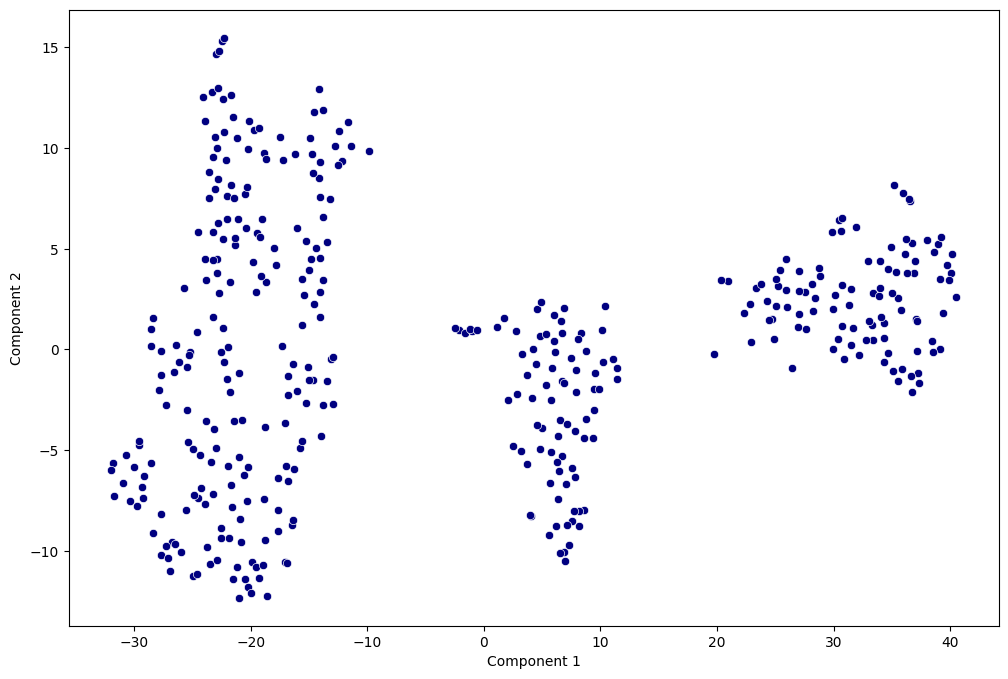

In [102]:
# creating a t_sne plot for 2 components

plt.figure(figsize=(12,8))

sns.scatterplot(x=df_tsne["Component 1"], y=df_tsne["Component 2"],
                color="navy")

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

The t-SNE visualization shows three naturally separated clusters of cars. T-SNE groups points based on overall similarity across all features.

In [103]:
#  Grouping components
def grouping(x):
    c1 = x["Component 1"]
    c2 = x["Component 2"]

    if (c1 > 0) and (c2 > -5):
        return "group_1"
    elif (-20 < c1 < 5):
        return "group_2"
    else:
        return "group_3"

df_tsne["group"] = df_tsne.apply(grouping, axis=1)

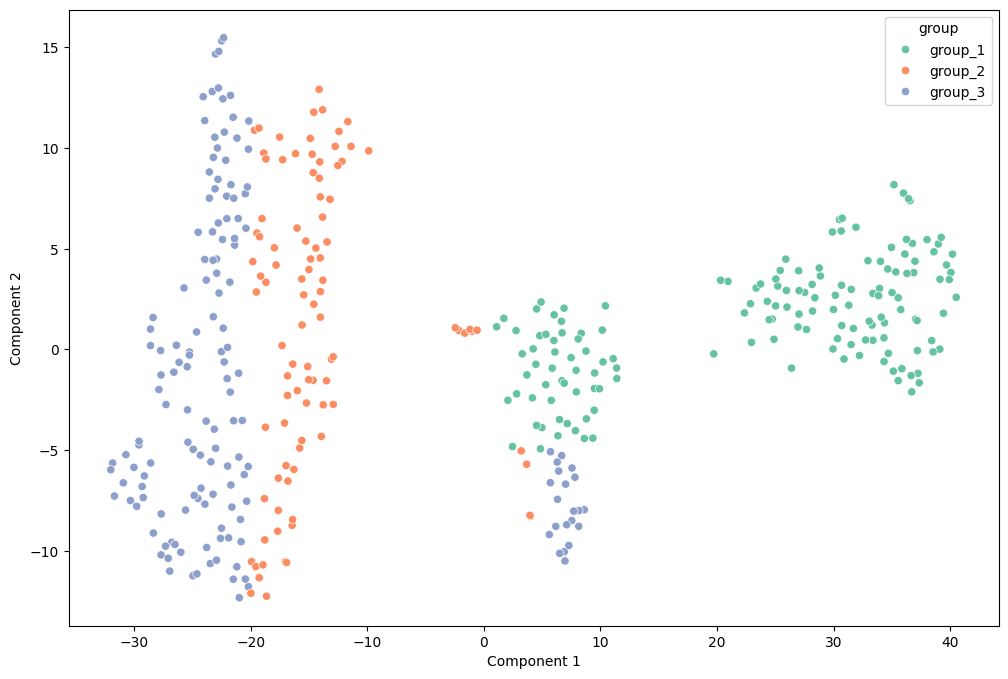

In [104]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=df_tsne["Component 1"], y=df_tsne["Component 2"],
                hue=df_tsne["group"],palette="Set2")

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

The t-SNE visualization separates the dataset into three major groups of vehicles.
The largest cluster corresponds to small, fuel-efficient economy cars, which share very similar engine size, horsepower, and weight.
The middle group represents mid-range vehicles with moderate performance characteristics.
The right group contains high-power, heavier cars, which differ significantly from the rest of the dataset and therefore form an isolated cluster.

In [105]:
# Creating a new column in df_tsne

df_tsne["group"] = df_tsne.apply(grouping, axis=1)

In [106]:
df_tsne

,Component 1,Component 2,group
0,36.707752,-2.108404,group_1
1,37.192513,-0.058722,group_1
2,37.241322,-1.185374,group_1
3,36.654381,-1.296686,group_1
4,37.348392,-1.658431,group_1
...,...,...,...
393,-14.034748,4.542985,group_2
394,-22.320072,15.480506,group_3
395,-19.144842,3.642219,group_2
396,-14.642265,8.776230,group_2


In [107]:
# Merging the groups

df["group"] = df_tsne["group"]

In [108]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,group
0,18.0,8,307.0,130.0,3504,12.0,70,group_1
1,15.0,8,350.0,165.0,3693,11.5,70,group_1
2,18.0,8,318.0,150.0,3436,11.0,70,group_1
3,16.0,8,304.0,150.0,3433,12.0,70,group_1
4,17.0,8,302.0,140.0,3449,10.5,70,group_1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,group_2
394,44.0,4,97.0,52.0,2130,24.6,82,group_3
395,32.0,4,135.0,84.0,2295,11.6,82,group_2
396,28.0,4,120.0,79.0,2625,18.6,82,group_2


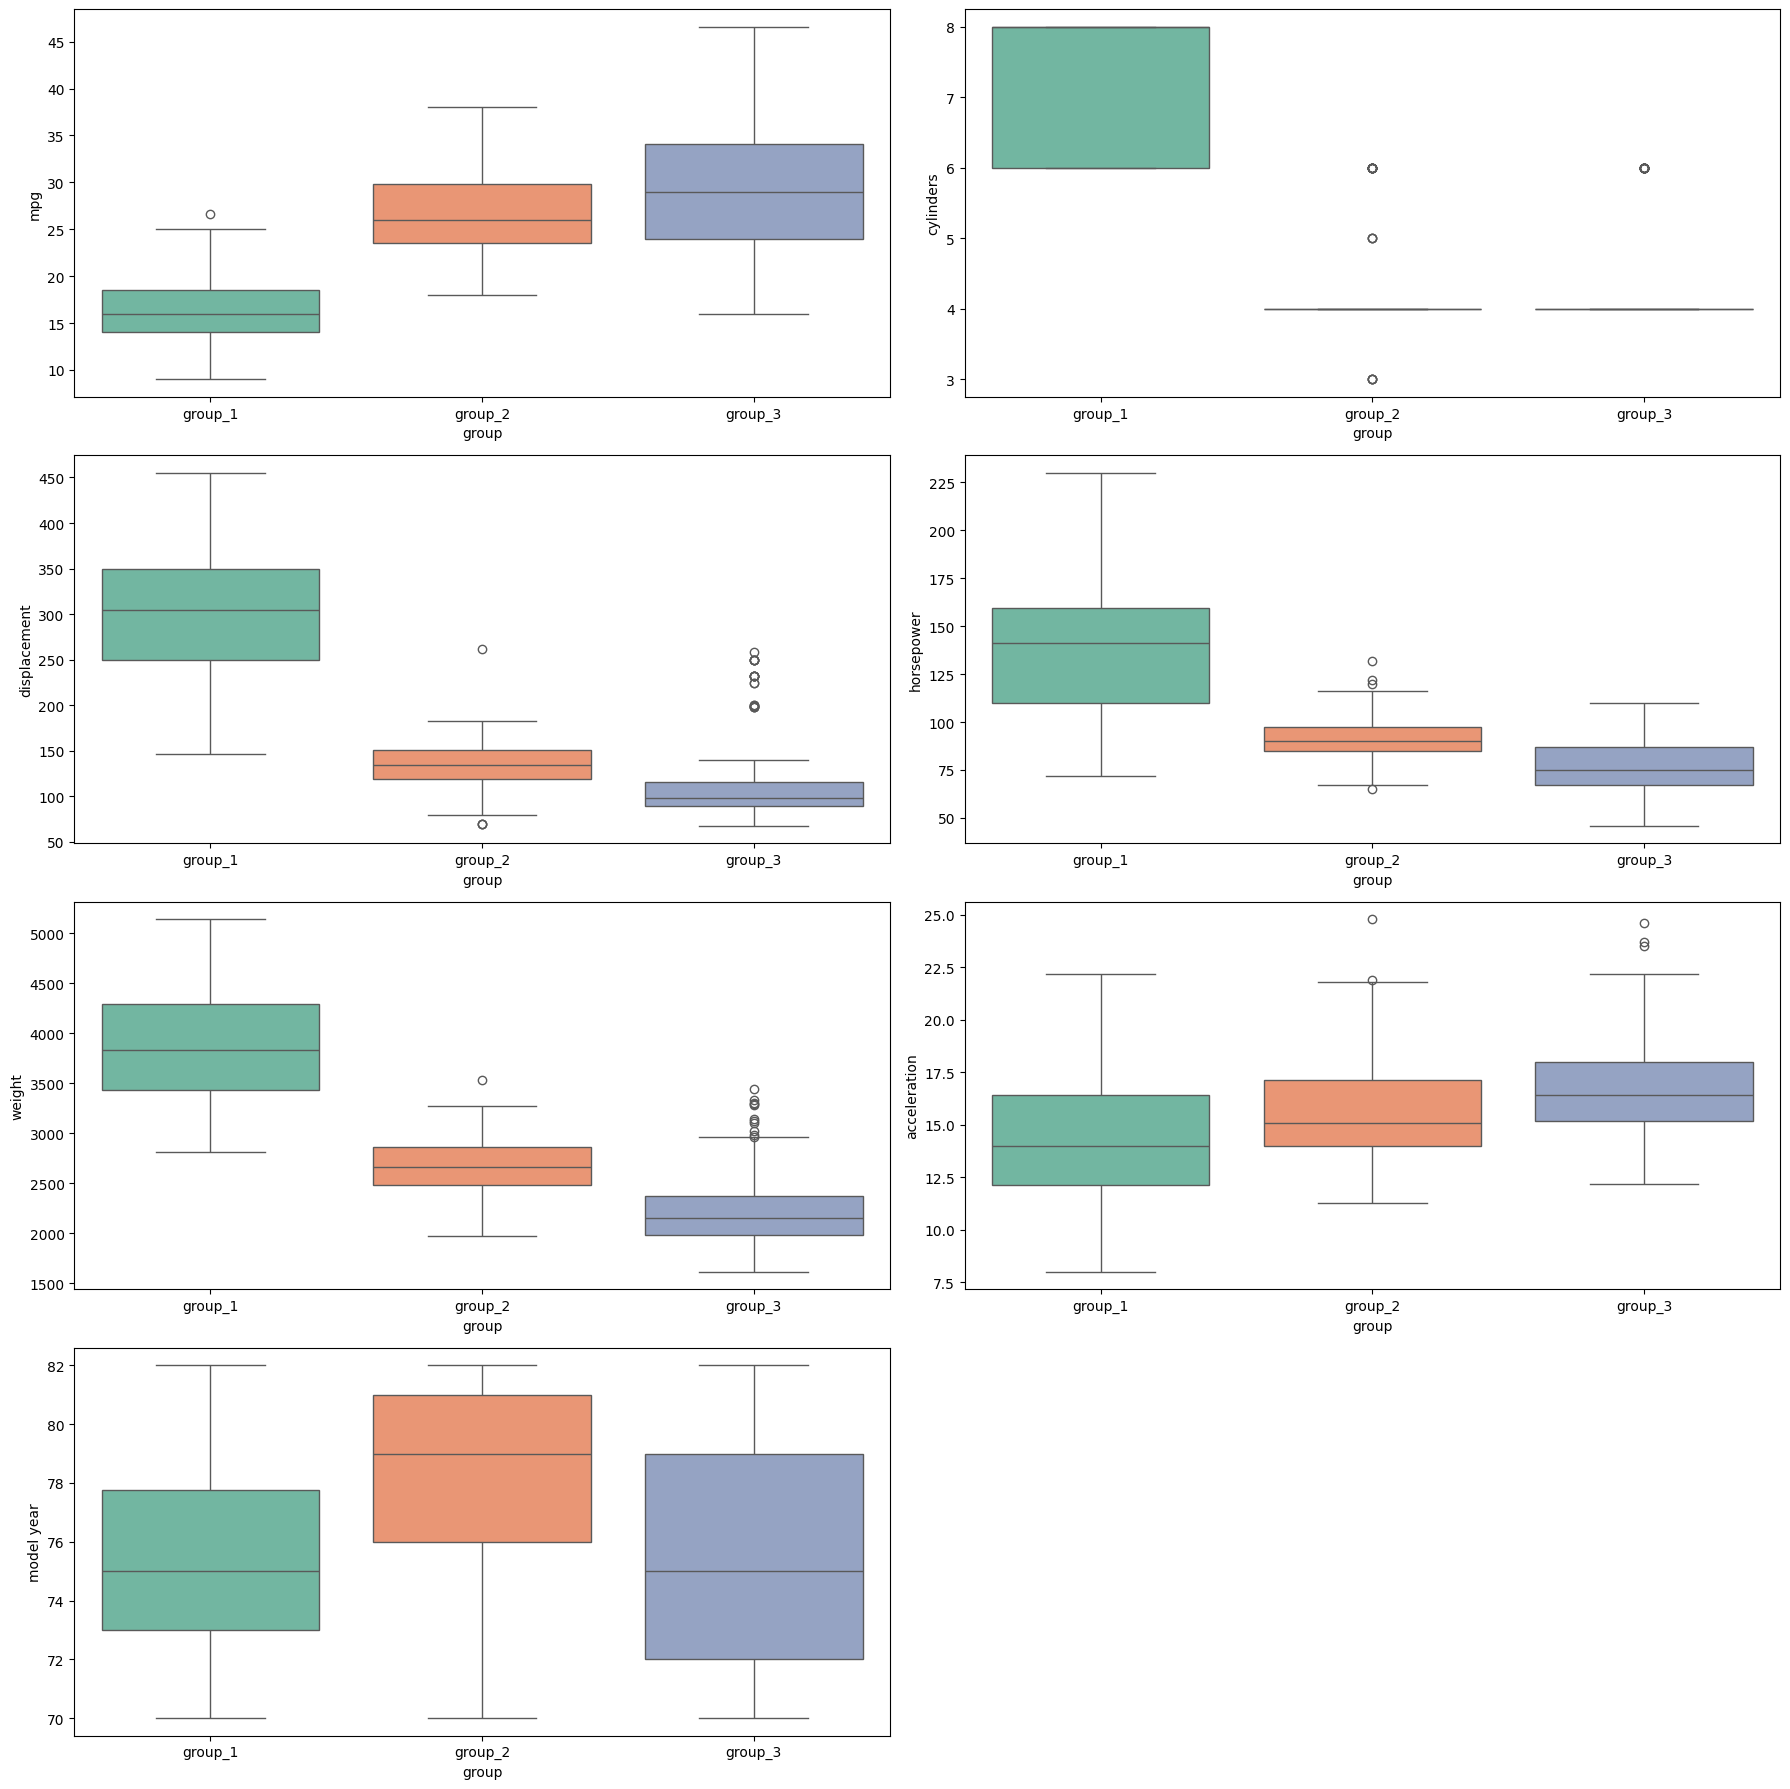

In [109]:
plt.figure(figsize=(18,18))

for i, var in enumerate(df.columns[:-1]):
  plt.subplot(4, 2, i+1)
  sns.boxplot(data=df, x="group", y=var, palette="Set2", hue="group")

plt.tight_layout()
plt.show()

Group 1 is characterized by larger and heavier vehicles. Cars in this group tend to have higher displacement and horsepower, are often equipped with more cylinders, and generally exhibit lower fuel efficiency. Overall, this group represents larger, more power vehicles with higher fuel consumption.

Group 2 consists mainly of mid-sized cars. These vehicles show moderate values across horsepower, displacement, and weight, with fuel efficiency that falls between the other two groups. This group can be seen as a transitional segment between larger, high-power cars and smaller, more efficient ones.

Group 3 includes lighter vehicles with smaller engines. Cars in this group typically have lower horsepower and displacement, are often four-cylinder models, and achieve higher fuel efficiency. This segment represents smaller, more fuel-efficient vehicles.

## **Actionable Insights and Recommendations**

The analysis reveals a clear structure in the dataset, with vehicles naturally separating into three distinct profiles driven primarily by engine size, weight, horsepower, and fuel efficiency. These features move together in a consistent and intuitive way: larger and more powerful cars tend to be heavier and less fuel-efficient, while smaller and lighter cars achieve higher MPG.

This structure highlights a clear spectrum of vehicle types rather than random variation, making the dataset well suited for segmentation and targeted decision-making.



**Recommendations**

Based on the analysis, the vehicles can be segmented into three broad groups, each corresponding to a different customer profile:

1) Power-focused vehicles: Larger, heavier cars with higher engine displacement and horsepower, typically associated with lower fuel efficiency. These vehicles appeal to customers who prioritize performance, engine characteristics, and driving experience over fuel economy.

2) Balanced mid-range vehicles: Cars with moderate size, weight, and engine power that offer a balance between performance and efficiency. This group may appeal to buyers seeking versatility, reliability, and reasonable operating costs.

3) Efficiency-oriented vehicles: Smaller, lighter cars with lower engine power and higher MPG. These vehicles are likely to attract budget-conscious buyers who value fuel efficiency, ease of maintenance, and practicality.

These segments can be used to guide how cars are positioned and marketed. For example, performance-oriented vehicles can be promoted by focusing on engine size, horsepower, and driving experience, while more efficient models can be marketed around fuel savings, ease of maintenance, and everyday practicality.

Since fuel-efficient cars make up a large part of the dataset, focusing more attention on this group could help reach a wider audience and support faster sales.